In [37]:
import os, sys, glob
import numpy as np
from subprocess import call
from scipy.optimize import curve_fit


## Basic parameters

In [38]:
#Arrhenius parameters
TA = 0.9
LA = 1.44
Ao = 0.17
DHo = 2.693
TauA =3.529

## dynamic properties
Temp = np.loadtxt('./Thermo')[:,2]
Tau = np.loadtxt('./Tau2_FSQ')[:, 0]
ASL = np.loadtxt('./Peak1_ASL')[:, 2]
DeltaG = Temp*np.log(Tau/Ao)

In [39]:
Data = np.zeros((len(Temp), 4))
Data[:,0] = Temp
Data[:,1] = Tau
Data[:,2] = ASL/LA
Data[:,3] = DeltaG

Data_LT = Data[Temp <= TA]
Data_HT = Data[Temp > TA]

## Fit the model include entropy


In [40]:

X = Data_LT[:,0]           # T            
ASL_Norm = Data_LT[:,2]	              
Y = np.log(Data_LT[:,1])	# L/LA (T < TA)
def func(X, DSo):
    T,ASL_Norm=X[:,0],X[:,1]
    y = np.log(TauA) + (DHo/T - DSo)*(ASL_Norm) - (DHo/TA - DSo)
    return (y)

XX = np.column_stack((X,ASL_Norm))
popt, pcov = curve_fit(func, XX, Y, p0=[0.8])
DeltaHo = DHo
DeltaSo = popt[0]

In [41]:
Tauo = TauA*np.exp(DeltaSo - DeltaHo/TA)

Temp = Data_LT[:,0]
Tau = Data_LT[:,1]
ASL_Norm = Data_LT[:,2]

X = (DeltaHo - DeltaSo*Temp)*ASL_Norm/Temp
Y = np.log(Tau/Tauo)

### plot the model

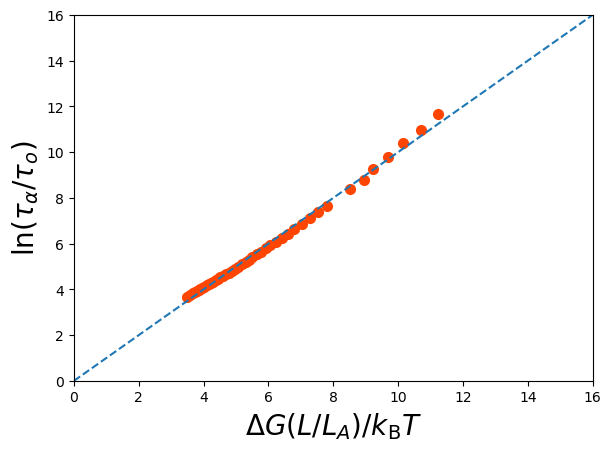

In [46]:
import matplotlib.pyplot as plt

cm = plt.get_cmap('rainbow')

fig, ((ax1)) = plt.subplots(1, 1, figsize=(6, 4.4), constrained_layout=True)

ax1.set_xlim(0, 16)
ax1.set_ylim(0,16)
ax1.plot(X, Y, 'o', color='orangered', markersize=7)
ax1.set_xlabel(r'$\Delta G(L/L_A)/k_{\mathrm{B}}T$', fontsize=20)
ax1.set_ylabel(r'$\ln(\tau_{\alpha}/\tau_o)$', fontsize=20)

x = np.linspace(0, 16, 100)
y = x
ax1.plot(x, y, '--', linewidth=1.5)


## Fit the model without entropy

In [43]:
X = Data_LT[:,0]           # T            
ASL_Norm = Data_LT[:,2]	              
Y = np.log(Data_LT[:,1])	# L/LA (T < TA)
def func(X,tauo, DGo):
    T,ASL_Norm=X[:,0],X[:,1]
    y = tauo + (DGo/T )*(ASL_Norm)
    return (y)

XX = np.column_stack((X,ASL_Norm))
popt, pcov = curve_fit(func, XX, Y, p0=[0.8,0.8])
tauo = np.exp(popt[0])
DeltaGo = popt[1]

In [44]:

Temp = Data_LT[:,0]
Tau = Data_LT[:,1]
ASL_Norm = Data_LT[:,2]

X = (DeltaGo)*ASL_Norm/Temp
Y = np.log(Tau/tauo)

### plot the model

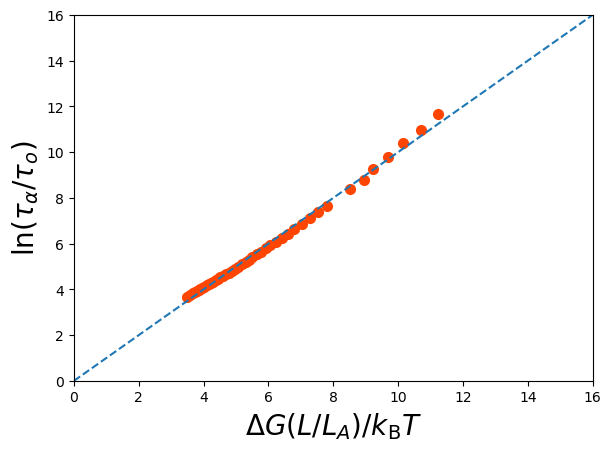

In [47]:
import matplotlib.pyplot as plt

cm = plt.get_cmap('rainbow')

fig, ((ax1)) = plt.subplots(1, 1, figsize=(6, 4.4), constrained_layout=True)

ax1.set_xlim(0, 16)
ax1.set_ylim(0,16)
ax1.plot(X, Y, 'o', color='orangered', markersize=7)
ax1.set_xlabel(r'$\Delta G(L/L_A)/k_{\mathrm{B}}T$', fontsize=20)
ax1.set_ylabel(r'$\ln(\tau_{\alpha}/\tau_o)$', fontsize=20)

x = np.linspace(0, 16, 100)
y = x
ax1.plot(x, y, '--', linewidth=1.5)